# Práctica 3 - IA en Educación

In [1]:
import pandas as pd

## Tarea 1

In [4]:
df_messages = pd.read_csv("data/forum_messages.csv")
df_topics = pd.read_csv("data/forum_topics.csv")

In [5]:
# Mostrar las primeras filas
df_messages.head()

,Id,ForumTopicId,PostUserId,PostDate,ReplyToForumMessageId,Message,Medal,MedalAwardDate
0,1680657,230748,6260570,2022-02-08 00:26:04,1263527.0,"Nice feature, thanks!",NaN,NaN
1,1680081,295170,4554096,2022-02-07 15:10:43,1618205.0,This is great!!!,NaN,NaN
2,1679992,295170,1178699,2022-02-07 14:14:10,1678824.0,Hi - thanks for your suggestion! We're alway...,NaN,NaN
3,1678824,295170,2589411,2022-02-06 20:06:25,1618205.0,Hi thanks for the feature it seems useful. Do...,NaN,NaN
4,1678817,302113,2589411,2022-02-06 19:56:57,1658292.0,"Great updates. for you to know, sometimes the ...",NaN,NaN


In [6]:
# Mostrar las primeras filas
df_topics.head()

,Id,ForumId,KernelId,LastForumMessageId,FirstForumMessageId,CreationDate,LastCommentDate,Title,IsSticky,TotalViews,Score,TotalMessages,TotalReplies,feedback_type
0,302908,809,NaN,1670877.0,1663249.0,2022-01-24 23:05:57,02/01/2022 00:24:12,[Product Update] Increased session runtimes fo...,True,0,43,11,10,product_update
1,302113,809,NaN,1678817.0,1658292.0,2022-01-20 22:41:06,02/06/2022 19:56:57,[Notebooks Update] Revised dark theme for the ...,True,0,16,17,16,product_update
2,295394,809,NaN,1641954.0,1619355.0,2021-12-15 21:15:06,01/07/2022 21:12:00,[Product Update] New and improved global navig...,True,0,16,3,2,product_update
3,295170,809,NaN,1680081.0,1618205.0,2021-12-14 18:50:32,02/07/2022 15:10:43,[Feature Launch]: Save Notebooks to GitHub,True,0,50,61,60,product_launch
4,294337,809,NaN,1646927.0,1613404.0,2021-12-09 23:40:36,01/12/2022 07:17:18,[Product Launch] Introducing Community Competi...,True,0,46,18,17,product_launch


## Tarea 2

### Detección de tópicos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# ----------------------------- PASO 1: PREPROCESAMIENTO -----------------------------

# Preprocesamiento de texto
def clean_text(text):
    if pd.isna(text):
        return ""
    return text.lower()

df_messages["Cleaned_Message"] = df_messages["Message"].apply(clean_text)

In [ ]:
# ----------------------------- PASO 2: DETECCIÓN DE TEMAS -----------------------------

# Vectorizar el texto con TF-IDF para la detección de temas
vectorizer = TfidfVectorizer(stop_words="english", max_features=500)
X = vectorizer.fit_transform(df_messages["Cleaned_Message"])

# Aplicar LDA para detectar los temas más recurrentes
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Obtener las palabras clave por tema
words = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    topics.append({"Topic": f"Tema {topic_idx+1}", "Top Words": ", ".join(top_words)})

# Convertir en DataFrame y mostrar
df_topics_lda = pd.DataFrame(topics)

In [9]:
df_topics_lda

,Topic,Top Words
0,Tema 1,"notebook, good, useful, version, thanks, like,..."
1,Tema 2,"thanks, team, sharing, issue, ll, know, feedba..."
2,Tema 3,"gpu, really, instance, gcp, cool, did, quota, ..."
3,Tema 4,"great, thanks, thank, nice, feature, awesome, ..."
4,Tema 5,"dataset, script, kernel, data, datasets, kerne..."


Hemos realizado este ejercicio mediante el uso de la vectorización por la técnica TFIDF y posteriormente la detección de tópicos en los mensajes del foro mediante el uso de LDA con 5 componentes, que podemos clasificar como:

- Tema 1: Relacionado con notebooks, versiones y comentarios positivos.
- Tema 2: Feedback general, problemas y comunicación con el equipo de Kaggle.
- Tema 3: Uso de GPU en GCP, cuotas y rendimiento.
- Tema 4: Agradecimientos y reacciones a nuevas características.
- Tema 5: Trabajo con datasets y kernels en Kaggle.


### Identificar temas con más dudas

Hemos identificado los temas con más dudas en los foros, considerando tanto el **número de respuestas** como la **cantidad de preguntas explícitas** en los mensajes.

In [10]:
# ----------------------------- PASO 3: DETECTAR TEMAS CON MÁS DUDAS -----------------------------

# Contar la cantidad de respuestas por tema
df_replies = df_messages.groupby("ForumTopicId")["ReplyToForumMessageId"].count().reset_index()
df_replies.columns = ["ForumTopicId", "Num_Replies"]

# Identificar los mensajes con preguntas (contienen "?")
df_messages["Has_Question"] = df_messages["Cleaned_Message"].apply(lambda x: "?" in x)
df_questions = df_messages.groupby("ForumTopicId")["Has_Question"].sum().reset_index()
df_questions.columns = ["ForumTopicId", "Num_Questions"]

# Unir ambas métricas y ordenar por mayor número de dudas
df_doubts = df_replies.merge(df_questions, on="ForumTopicId").sort_values(by="Num_Questions", ascending=False)

In [11]:
df_doubts

,ForumTopicId,Num_Replies,Num_Questions
52,159602,133,59
35,91185,58,25
36,92832,32,23
47,139884,60,19
72,227024,50,16
...,...,...,...
20,61922,0,0
75,235315,4,0
17,59393,0,0
61,177372,19,0


In [12]:
# ----------------------------- PASO 4: ASOCIAR TEMAS DETECTADOS CON LOS TEMAS CON MÁS DUDAS -----------------------------

# Unir los datos con los títulos de los foros
df_doubts_topics = df_doubts.merge(df_topics[["Id", "Title"]], left_on="ForumTopicId", right_on="Id").drop(columns=["Id"])

# Crear una función para asignar los temas detectados a los títulos de los foros
def assign_detected_topic(title):
    for _, row in df_topics_lda.iterrows():
        keywords = row["Top Words"].split(", ")
        if any(keyword in title.lower() for keyword in keywords):
            return row["Topic"]
    return "Unknown"

# Asignar los temas detectados a los títulos de los foros
df_doubts_topics["Detected_Topic"] = df_doubts_topics["Title"].apply(assign_detected_topic)

# Filtrar los temas que lograron asociarse con las categorías detectadas
df_final_doubts = df_doubts_topics[df_doubts_topics["Detected_Topic"] != "Unknown"].sort_values(by="Num_Questions", ascending=False)

In [13]:
df_final_doubts

,ForumTopicId,Num_Replies,Num_Questions,Title,Detected_Topic
0,159602,133,59,[Feature Launch] Upgrade to Notebooks on Googl...,Tema 1
1,91185,58,25,Feature Launch: Import scripts into notebook k...,Tema 1
2,92832,32,23,Product Update: New and improved Datasets home...,Tema 1
3,139884,60,19,Feature Launch: Version Naming and Quick Versions,Tema 1
4,227024,50,16,[Notebooks update] Editor upgrades,Tema 1
...,...,...,...,...,...
80,106160,0,0,Feature Launch: Find Other References,Tema 4
78,66460,0,0,Feature Launch: Dataset Diff History,Tema 2
77,67547,0,0,Feature Launch: Email Notifications,Tema 4
76,66457,0,0,Feature Launch: Dataset Diff History,Tema 2


## Tarea 3

### Detección de sentimientos

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_58558/3836260664.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax, palette=colors)


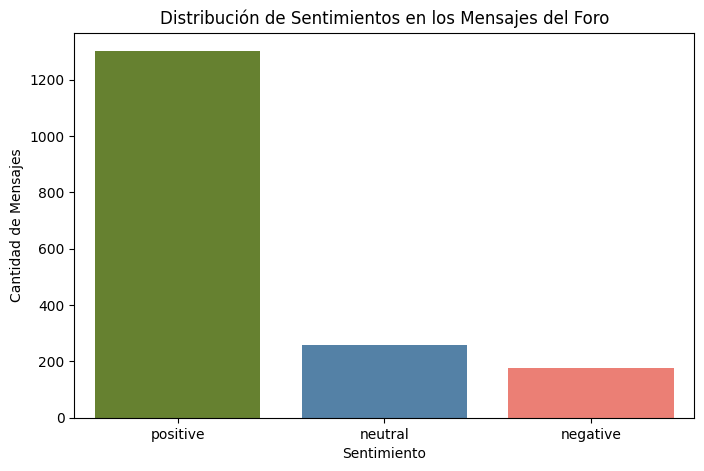

In [ ]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# Función para analizar el sentimiento
def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "neutral"
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

# Aplicar análisis de sentimiento a los mensajes
df_messages["Sentiment"] = df_messages["Message"].apply(get_sentiment)

# Contar la cantidad de mensajes por sentimiento
sentiment_counts = df_messages["Sentiment"].value_counts()

# Definir una paleta de colores personalizada
colors = ["#6B8E23", "#4682B4", "#FF6F61"]  # Verde Oliva, Azul Acero, Rojo

# Graficar la distribución de sentimientos con colores personalizados
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, ax=ax, palette=colors)
ax.set_xlabel("Sentimiento")
ax.set_ylabel("Cantidad de Mensajes")
ax.set_title("Distribución de Sentimientos en los Mensajes del Foro")
plt.show()

### Temáticas con más sentimientos negativos

In [22]:
# Unir los datos de mensajes con los títulos de los foros para tener contexto de los temas
df_sentiment_topics = df_messages.merge(df_topics[["Id", "Title"]], left_on="ForumTopicId", right_on="Id")

# Contar la cantidad de mensajes negativos por tema
df_negative_sentiment = df_sentiment_topics[df_sentiment_topics["Sentiment"] == "negative"].groupby("Title")["Sentiment"].count().reset_index()
df_negative_sentiment.columns = ["Title", "Num_Negative_Messages"]

# Ordenar por los temas con más mensajes negativos
df_negative_sentiment_sorted = df_negative_sentiment.sort_values(by="Num_Negative_Messages", ascending=False)
df_negative_sentiment_sorted

,Title,Num_Negative_Messages
28,[Feature Launch] Upgrade to Notebooks on Googl...,33
4,Feature Launch: Import scripts into notebook k...,15
33,[Notebooks update] Editor upgrades,11
15,Feature Launch: Version Naming and Quick Versions,8
13,Feature Launch: TensorBoard Support in Kaggle ...,8
30,[Feature Launch]: Save Notebooks to GitHub,7
40,[Notebooks update] Save Versions stop on error...,7
25,Product Update: Enable Internet Access on Kernels,6
14,Feature Launch: User Secrets,6
29,[Feature Launch]: Embedding and Linking Notebooks,5


## Tarea 4

### Nube de palabras

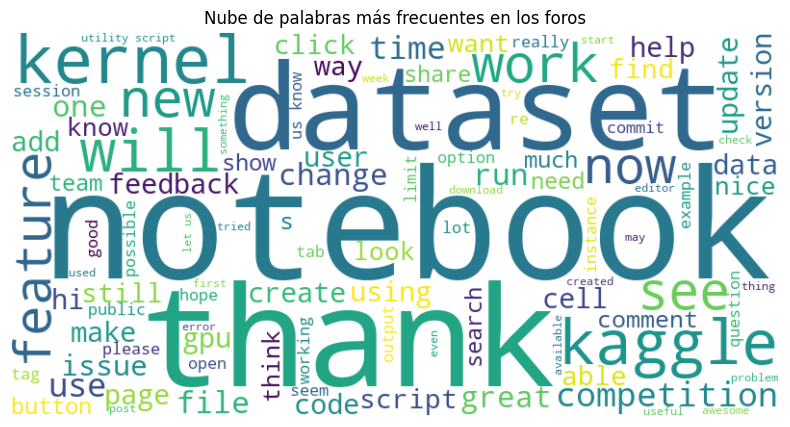

In [23]:
from wordcloud import WordCloud

# -------------------- 1. NUBE DE PALABRAS --------------------

# Concatenar todos los mensajes en un solo texto
all_text = " ".join(df_messages["Cleaned_Message"].dropna())

# Generar una nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(all_text)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras más frecuentes en los foros")
plt.show()

### Detección de palabras clave en mensajes negativos

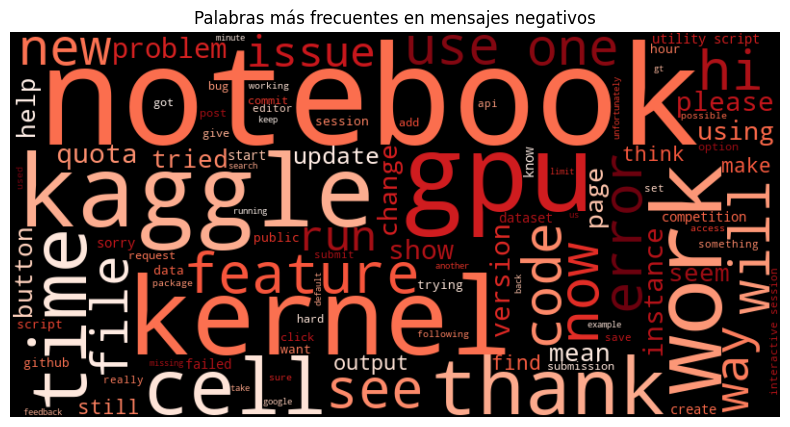

In [25]:
# -------------------- 2. PALABRAS MÁS FRECUENTES EN MENSAJES NEGATIVOS --------------------

# Filtrar solo mensajes negativos
negative_text = " ".join(df_messages[df_messages["Sentiment"] == "negative"]["Cleaned_Message"].dropna())

# Generar nube de palabras para mensajes negativos
wordcloud_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds", max_words=100).generate(negative_text)

# Mostrar la nube de palabras para mensajes negativos
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Palabras más frecuentes en mensajes negativos")
plt.show()


### Análisis de la longitud de los mensajes

In [26]:
# Agregar una columna con la longitud del mensaje
df_messages["Message_Length"] = df_messages["Cleaned_Message"].apply(lambda x: len(x.split()))

# Calcular el promedio de longitud por tipo de sentimiento
length_by_sentiment = df_messages.groupby("Sentiment")["Message_Length"].mean().reset_index()
length_by_sentiment.columns = ["Sentiment", "Avg_Message_Length"]
length_by_sentiment

,Sentiment,Avg_Message_Length
0,negative,43.346591
1,neutral,16.988372
2,positive,45.516129


Los mensajes negativos y positivos son más largos en comparación con los neutrales. Esto sugiere que los usuarios dedican más palabras a expresar satisfacción o insatisfacción con un producto o funcionalidad.

Sin embargo, los mensajes neutrales (como preguntas o comentarios breves) suelen ser más cortos y directos.